In [1]:
import cv2
print("✅ cv2 version:", cv2.__version__)


✅ cv2 version: 4.10.0


In [6]:
import os
import numpy as np
import cv2
from glob import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K


In [7]:
IMG_SIZE = 256
pixel_per_cm = 72

def load_data(image_dir, mask_dir):
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
    mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))
    images, masks = [], []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        images.append(img)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
        masks.append(np.expand_dims(mask, axis=-1))
    return np.array(images), np.array(masks)

def build_unet(input_shape=(256, 256, 3)):
    def conv_block(x, filters):
        x = Conv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    def encoder_block(x, filters):
        s = conv_block(x, filters)
        p = MaxPooling2D((2, 2))(s)
        return s, p

    def decoder_block(x, skip, filters):
        x = Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
        x = Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    return Model(inputs, outputs)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def calculate_iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return intersection / (union + 1e-7)

def get_endpoint_y(mask):
    coords = np.argwhere(mask[..., 0] > 0.5)
    return np.max(coords[:, 0]) if len(coords) > 0 else None

def run_fold(fold_index):
    base_path = f"ETT-v3/Fold{fold_index}"
    x_train, y_train = load_data(os.path.join(base_path, "train"), os.path.join(base_path, "trainannot"))
    x_val, y_val = load_data(os.path.join(base_path, "val"), os.path.join(base_path, "valannot"))
    x_test, y_test = load_data(os.path.join(base_path, "test"), os.path.join(base_path, "testannot"))

    print(f"Fold{fold_index} - Train: {len(x_train)}, Val: {len(x_val)}, Test: {len(x_test)}")

    model = build_unet()
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=["accuracy"])

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint(f"unet_fold{fold_index}_best.h5", save_best_only=True)
    ]

    print(f"Fold{fold_index} - Start training...")
    model.fit(x_train, y_train,
              validation_data=(x_val, y_val),
              batch_size=8,
              epochs=30,
              callbacks=callbacks,
              verbose=1)

    print(f"Fold{fold_index} - Start evaluation...")

    ious = []
    errors, acc_05cm, acc_10cm, valid = [], 0, 0, 0
    for i in range(len(x_test)):
        pred = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)[0]
        pred = (pred > 0.5).astype(np.uint8)

        ious.append(calculate_iou(y_test[i], pred))

        true_y = get_endpoint_y(y_test[i])
        pred_y = get_endpoint_y(pred)
        if true_y is not None and pred_y is not None:
            error_pixel = abs(pred_y - true_y)
            errors.append(error_pixel / pixel_per_cm)
            valid += 1
            if error_pixel <= 36:
                acc_05cm += 1
            if error_pixel <= 72:
                acc_10cm += 1

    print(f"Fold{fold_index} Results:")
    print(f"  Mean IOU: {np.mean(ious):.4f}")
    print(f"  Mean Endpoint Error: {np.mean(errors):.2f} cm")
    print(f"  Accuracy within 0.5 cm: {acc_05cm / valid:.2%}")
    print(f"  Accuracy within 1.0 cm: {acc_10cm / valid:.2%}")

    return {
        "fold": fold_index,
        "mean_iou": np.mean(ious),
        "mean_error_cm": np.mean(errors),
        "acc_05cm": acc_05cm / valid if valid else 0,
        "acc_10cm": acc_10cm / valid if valid else 0
    }


In [8]:
result_fold3 = run_fold(3)


Fold3 - Train: 287, Val: 47, Test: 47
Fold3 - Start training...
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.2944 - loss: 0.9731 

36/36 ━━━━━━━━━━━━━━━━━━━━ 970s 26s/step - accuracy: 0.2998 - loss: 0.9728 - val_accuracy: 0.9744 - val_loss: 0.9836
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 959s 27s/step - accuracy: 0.9188 - loss: 0.9228 - val_accuracy: 0.9913 - val_loss: 0.9837
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.9655 - loss: 0.8932 

36/36 ━━━━━━━━━━━━━━━━━━━━ 962s 27s/step - accuracy: 0.9656 - loss: 0.8930 - val_accuracy: 0.9913 - val_loss: 0.9835
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 942s 26s/step - accuracy: 0.9792 - loss: 0.8716 - val_accuracy: 0.9913 - val_loss: 0.9839
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9836 - loss: 0.8509 

36/36 ━━━━━━━━━━━━━━━━━━━━ 818s 23s/step - accuracy: 0.9836 - loss: 0.8508 - val_accuracy: 0.9911 - val_loss: 0.9819
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9859 - loss: 0.8382 

36/36 ━━━━━━━━━━━━━━━━━━━━ 793s 22s/step - accuracy: 0.9859 - loss: 0.8381 - val_accuracy: 0.9890 - val_loss: 0.9703
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 788s 22s/step - accuracy: 0.9873 - loss: 0.8263 - val_accuracy: 0.9913 - val_loss: 0.9850
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 787s 22s/step - accuracy: 0.9888 - loss: 0.8098 - val_accuracy: 0.9913 - val_loss: 0.9840
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 794s 22s/step - accuracy: 0.9913 - loss: 0.7905 - val_accuracy: 0.9913 - val_loss: 0.9854
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9910 - loss: 0.7735 

36/36 ━━━━━━━━━━━━━━━━━━━━ 803s 22s/step - accuracy: 0.9910 - loss: 0.7734 - val_accuracy: 0.9918 - val_loss: 0.9600
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9913 - loss: 0.7603 

36/36 ━━━━━━━━━━━━━━━━━━━━ 866s 24s/step - accuracy: 0.9913 - loss: 0.7601 - val_accuracy: 0.9925 - val_loss: 0.9353
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9928 - loss: 0.7308 

36/36 ━━━━━━━━━━━━━━━━━━━━ 860s 24s/step - accuracy: 0.9928 - loss: 0.7308 - val_accuracy: 0.9931 - val_loss: 0.9100
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9932 - loss: 0.7095 

36/36 ━━━━━━━━━━━━━━━━━━━━ 791s 22s/step - accuracy: 0.9932 - loss: 0.7094 - val_accuracy: 0.9942 - val_loss: 0.8404
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9941 - loss: 0.6872 

36/36 ━━━━━━━━━━━━━━━━━━━━ 787s 22s/step - accuracy: 0.9941 - loss: 0.6871 - val_accuracy: 0.9943 - val_loss: 0.8308
Epoch 15/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9941 - loss: 0.6619 

36/36 ━━━━━━━━━━━━━━━━━━━━ 783s 22s/step - accuracy: 0.9941 - loss: 0.6618 - val_accuracy: 0.9952 - val_loss: 0.7707
Epoch 16/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 784s 22s/step - accuracy: 0.9950 - loss: 0.6354 - val_accuracy: 0.9945 - val_loss: 0.7780
Epoch 17/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9940 - loss: 0.6260 

36/36 ━━━━━━━━━━━━━━━━━━━━ 787s 22s/step - accuracy: 0.9940 - loss: 0.6257 - val_accuracy: 0.9944 - val_loss: 0.7086
Epoch 18/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9949 - loss: 0.5962 

36/36 ━━━━━━━━━━━━━━━━━━━━ 782s 22s/step - accuracy: 0.9949 - loss: 0.5959 - val_accuracy: 0.9957 - val_loss: 0.6860
Epoch 19/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9951 - loss: 0.5635 

36/36 ━━━━━━━━━━━━━━━━━━━━ 784s 22s/step - accuracy: 0.9951 - loss: 0.5633 - val_accuracy: 0.9960 - val_loss: 0.6167
Epoch 20/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 780s 22s/step - accuracy: 0.9960 - loss: 0.5379 - val_accuracy: 0.9963 - val_loss: 0.6290
Epoch 21/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9962 - loss: 0.5014 

36/36 ━━━━━━━━━━━━━━━━━━━━ 777s 22s/step - accuracy: 0.9962 - loss: 0.5012 - val_accuracy: 0.9965 - val_loss: 0.5899
Epoch 22/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 771s 21s/step - accuracy: 0.9962 - loss: 0.4709 - val_accuracy: 0.9961 - val_loss: 0.5940
Epoch 23/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9967 - loss: 0.4496 

36/36 ━━━━━━━━━━━━━━━━━━━━ 774s 22s/step - accuracy: 0.9966 - loss: 0.4495 - val_accuracy: 0.9958 - val_loss: 0.5083
Epoch 24/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 798s 22s/step - accuracy: 0.9966 - loss: 0.4247 - val_accuracy: 0.9959 - val_loss: 0.5700
Epoch 25/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 50s/step - accuracy: 0.9964 - loss: 0.3869 

36/36 ━━━━━━━━━━━━━━━━━━━━ 1798s 51s/step - accuracy: 0.9965 - loss: 0.3871 - val_accuracy: 0.9959 - val_loss: 0.4644
Epoch 26/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1730s 49s/step - accuracy: 0.9967 - loss: 0.3795 - val_accuracy: 0.9961 - val_loss: 0.4907
Epoch 27/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 54s/step - accuracy: 0.9964 - loss: 0.3568 

36/36 ━━━━━━━━━━━━━━━━━━━━ 1932s 54s/step - accuracy: 0.9964 - loss: 0.3566 - val_accuracy: 0.9962 - val_loss: 0.4356
Epoch 28/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2084s 59s/step - accuracy: 0.9970 - loss: 0.3260 - val_accuracy: 0.9963 - val_loss: 0.4500
Epoch 29/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 81s/step - accuracy: 0.9969 - loss: 0.3017  

36/36 ━━━━━━━━━━━━━━━━━━━━ 2905s 82s/step - accuracy: 0.9969 - loss: 0.3017 - val_accuracy: 0.9961 - val_loss: 0.4344
Epoch 30/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 42s/step - accuracy: 0.9970 - loss: 0.2934 

36/36 ━━━━━━━━━━━━━━━━━━━━ 1526s 43s/step - accuracy: 0.9970 - loss: 0.2932 - val_accuracy: 0.9962 - val_loss: 0.3972
Fold3 - Start evaluation...
Fold3 Results:
  Mean IOU: 0.6217
  Mean Endpoint Error: 0.16 cm
  Accuracy within 0.5 cm: 93.48%
  Accuracy within 1.0 cm: 97.83%


In [9]:
import matplotlib.pyplot as plt

def visualize_prediction(index, x_test, y_test, model):
    image = x_test[index]
    true_mask = y_test[index]

    # 預測
    pred_mask = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # 畫圖
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(true_mask[..., 0], cmap='viridis')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_mask[..., 0], cmap='viridis')
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.suptitle(f"Test Sample {index} - Fold2", fontsize=14)
    plt.tight_layout()
    plt.show()


In [10]:
# 載入 Fold3 測試資料
x_test, y_test = load_data("ETT-v3/Fold3/test", "ETT-v3/Fold3/testannot")

# 載入最佳訓練模型權重（你之前有儲存為 .h5）
model = build_unet()
model.load_weights("unet_fold3_best.h5")

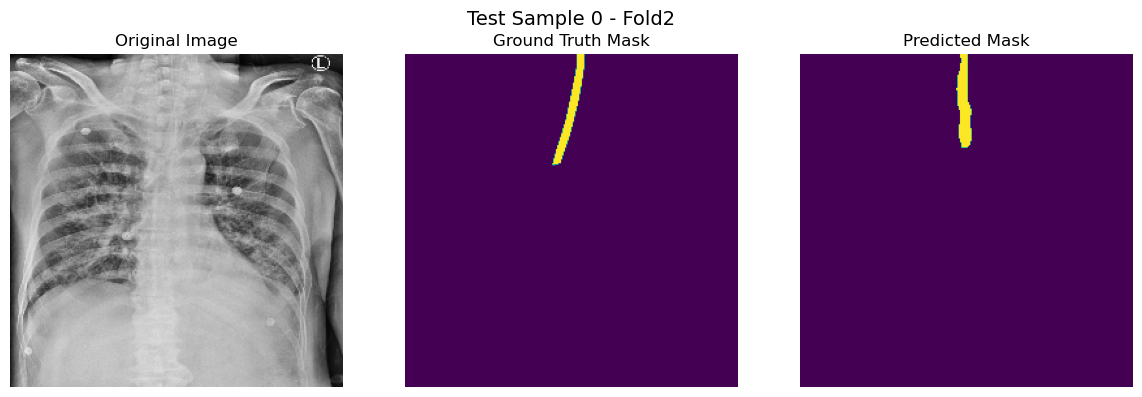

In [11]:
visualize_prediction(0, x_test, y_test, model)

In [12]:
def get_endpoint_coords(mask):
    coords = np.argwhere(mask[..., 0] > 0.5)
    if len(coords) == 0:
        return None
    return coords[np.argmax(coords[:, 0])]  # y 最大的點（最底端）

def visualize_with_endpoints(index, x_test, y_test, model, fold_num="X"):
    image = x_test[index]
    true_mask = y_test[index]

    # 預測遮罩
    pred_mask = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # 找端點座標
    true_coord = get_endpoint_coords(true_mask)
    pred_coord = get_endpoint_coords(pred_mask)

    # 畫圖
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(true_mask[..., 0], cmap='viridis')
    if true_coord is not None:
        axs[1].plot(true_coord[1], true_coord[0], 'ro')
        axs[1].text(true_coord[1]+2, true_coord[0], 'G', color='red', fontsize=12)
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_mask[..., 0], cmap='viridis')
    if pred_coord is not None:
        axs[2].plot(pred_coord[1], pred_coord[0], 'ro')
        axs[2].text(pred_coord[1]+2, pred_coord[0], 'Y', color='red', fontsize=12)
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.suptitle(f"Test Sample {index} – Fold{fold_num} (G: GT endpoint, Y: Pred endpoint)", fontsize=14)
    plt.tight_layout()
    plt.show()


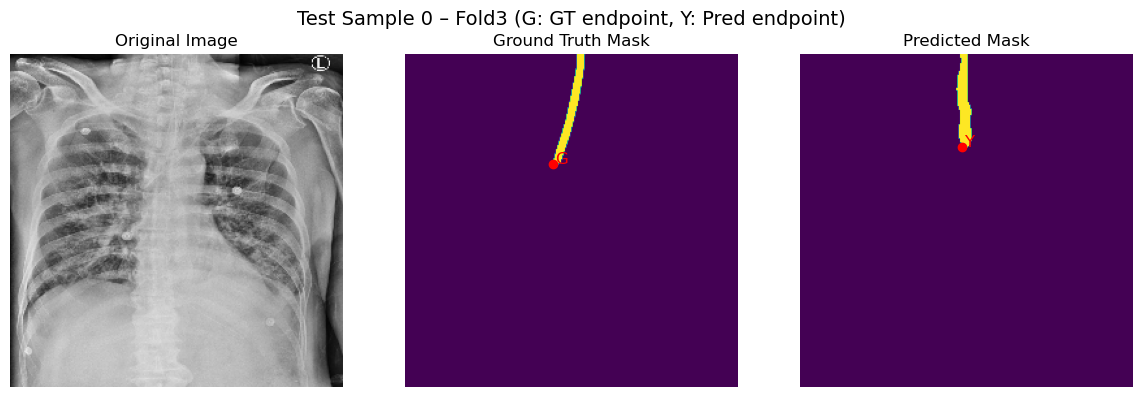

In [13]:
visualize_with_endpoints(0, x_test, y_test, model, fold_num="3")


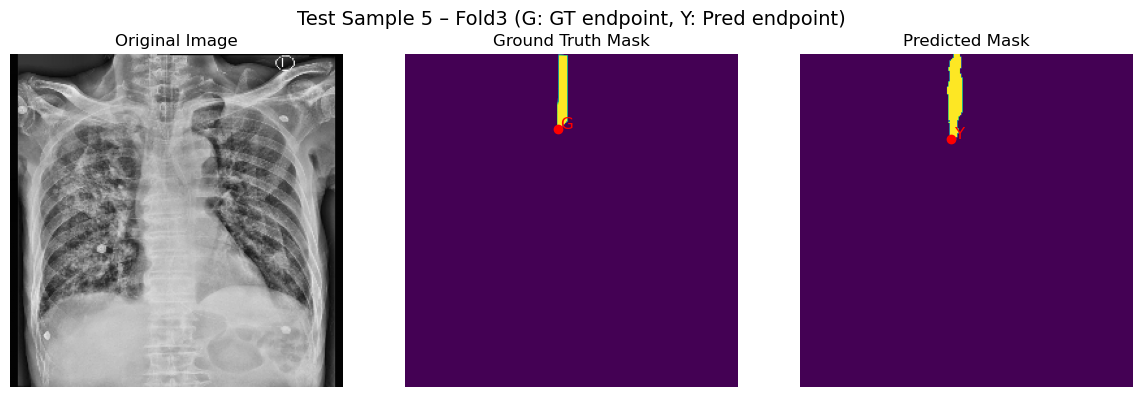

In [14]:
visualize_with_endpoints(5, x_test, y_test, model, fold_num="3")


In [15]:
result_fold4 = run_fold(4)


Fold4 - Train: 285, Val: 48, Test: 48
Fold4 - Start training...
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 180s/step - accuracy: 0.5051 - loss: 0.9693  

36/36 ━━━━━━━━━━━━━━━━━━━━ 6391s 181s/step - accuracy: 0.5082 - loss: 0.9690 - val_accuracy: 0.9044 - val_loss: 0.9842
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1757s 50s/step - accuracy: 0.9273 - loss: 0.9086 - val_accuracy: 0.9442 - val_loss: 0.9848
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 679s 19s/step - accuracy: 0.9739 - loss: 0.8619 - val_accuracy: 0.9907 - val_loss: 0.9862
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 589s 16s/step - accuracy: 0.9837 - loss: 0.8283 - val_accuracy: 0.9915 - val_loss: 0.9869
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 642s 18s/step - accuracy: 0.9858 - loss: 0.8072 - val_accuracy: 0.9915 - val_loss: 0.9873
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 629s 17s/step - accuracy: 0.9883 - loss: 0.7877 - val_accuracy: 0.9915 - val_loss: 0.9872
Fold4 - Start evaluation...
Fold4 Results:
  Mean IOU: 0.0015
  Mean Endpoint Error: 2.57 cm
  Accuracy within 0.5 cm: 0.00%
  Accuracy within 1.0 cm: 0.00%


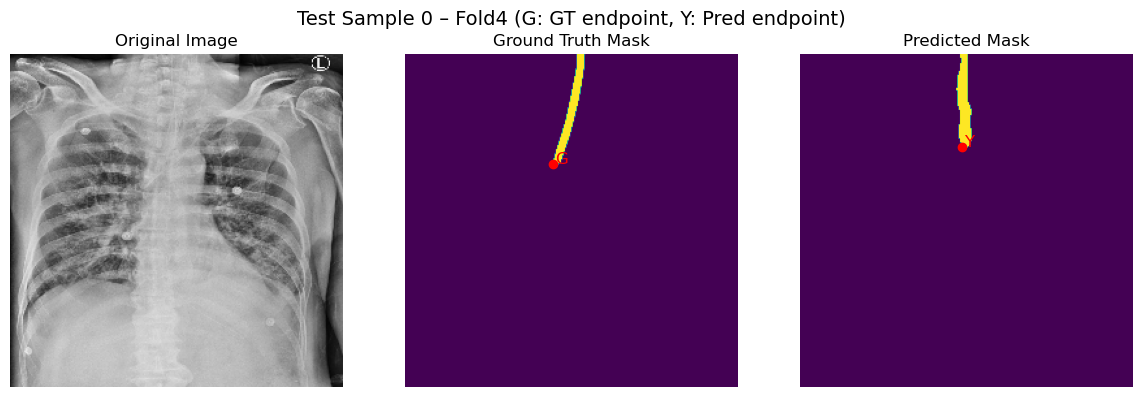

In [16]:
visualize_with_endpoints(0, x_test, y_test, model, fold_num="4")


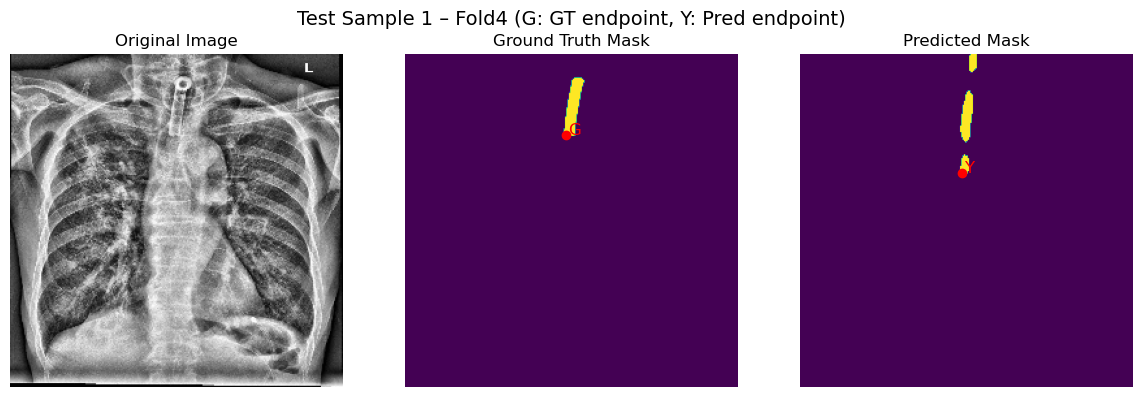

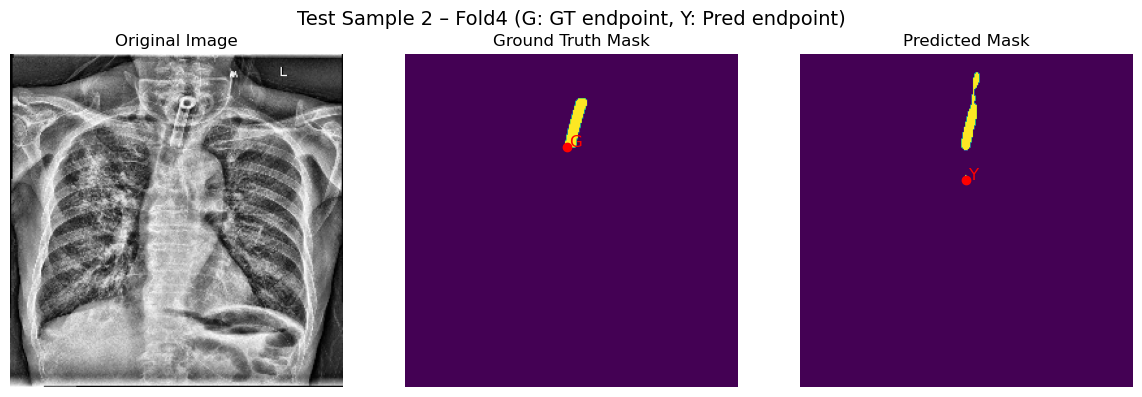

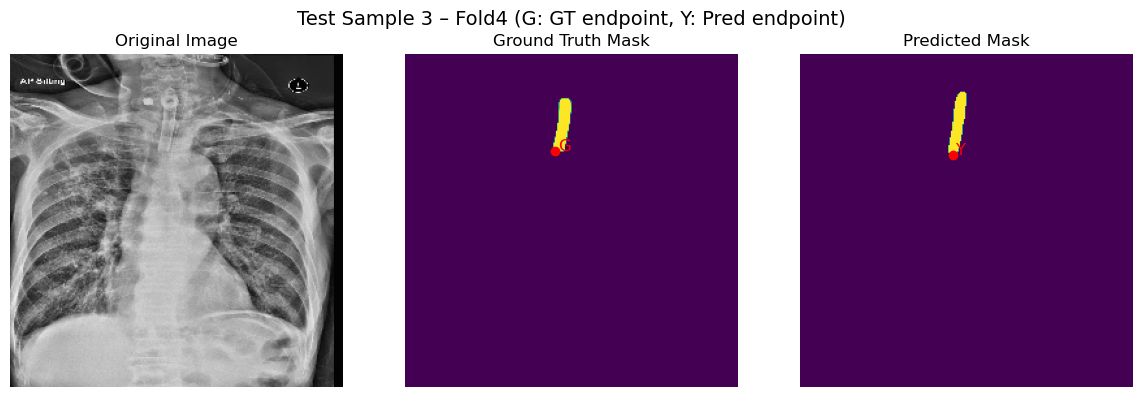

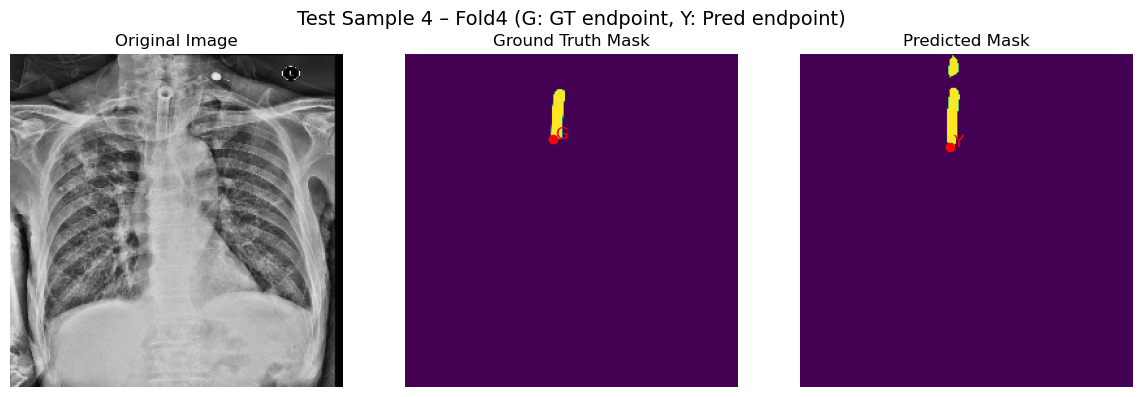

In [17]:
visualize_with_endpoints(1, x_test, y_test, model, fold_num="4")
visualize_with_endpoints(2, x_test, y_test, model, fold_num="4")
visualize_with_endpoints(3, x_test, y_test, model, fold_num="4")
visualize_with_endpoints(4, x_test, y_test, model, fold_num="4")


In [18]:
result_fold5 = run_fold(5)

Fold5 - Train: 285, Val: 48, Test: 48
Fold5 - Start training...
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.7076 - loss: 0.9599 

36/36 ━━━━━━━━━━━━━━━━━━━━ 683s 19s/step - accuracy: 0.7101 - loss: 0.9592 - val_accuracy: 0.9921 - val_loss: 0.9853
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 655s 18s/step - accuracy: 0.9699 - loss: 0.8336 - val_accuracy: 0.9921 - val_loss: 0.9858
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 657s 18s/step - accuracy: 0.9852 - loss: 0.7570 - val_accuracy: 0.9921 - val_loss: 0.9868
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 616s 17s/step - accuracy: 0.9884 - loss: 0.7107 - val_accuracy: 0.9921 - val_loss: 0.9865
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 583s 16s/step - accuracy: 0.9912 - loss: 0.6693 - val_accuracy: 0.9921 - val_loss: 0.9864
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 583s 16s/step - accuracy: 0.9920 - loss: 0.6375 - val_accuracy: 0.9921 - val_loss: 0.9871
Fold5 - Start evaluation...
Fold5 Results:
  Mean IOU: 0.0000
  Mean Endpoint Error: nan cm


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ZeroDivisionError: division by zero

In [19]:
# 載入 Fold5 測試集
x_test, y_test = load_data("ETT-v3/Fold5/test", "ETT-v3/Fold5/testannot")

# 看看哪些 mask 是全黑（和 Fold2 問題類似）
empty_masks = [i for i in range(len(y_test)) if np.max(y_test[i]) == 0]

print(f"Fold5 測試集共 {len(y_test)} 張，其中空白遮罩張數：{len(empty_masks)}")
print("空白遮罩 index：", empty_masks)


Fold5 測試集共 48 張，其中空白遮罩張數：0
空白遮罩 index： []


In [22]:
model = build_unet()
model.load_weights("unet_fold5_best.h5")

missing_pred = []

for i in range(len(x_test)):
    pred_mask = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)[0]
    pred_mask = (pred_mask > 0.3).astype(np.uint8)
    pred_y = get_endpoint_coords(pred_mask)
    if pred_y is None:
        missing_pred.append(i)

print(f"Fold5 測試集共有 {len(x_test)} 張")
print(f"預測遮罩中找不到端點 Y 的張數：{len(missing_pred)}")
print("Index:", missing_pred)


Fold5 測試集共有 48 張
預測遮罩中找不到端點 Y 的張數：0
Index: []


In [23]:
def get_endpoint_coords(mask, threshold=0.3):
    coords = np.argwhere(mask[..., 0] > threshold)
    if len(coords) == 0:
        return None
    return coords[np.argmax(coords[:, 0])]  # 取 y 最大（最下端）


In [24]:
def post_process_mask(mask):
    from scipy.ndimage import binary_closing
    closed = binary_closing(mask[..., 0], structure=np.ones((5, 5))).astype(np.uint8)
    return np.expand_dims(closed, axis=-1)

def run_fold(fold_index):
    print(f"Fold{fold_index} – Start training...")

    # 資料載入
    path = f"ETT-v3/Fold{fold_index}"
    x_train, y_train = load_data(f"{path}/train", f"{path}/trainannot")
    x_val, y_val = load_data(f"{path}/val", f"{path}/valannot")
    x_test, y_test = load_data(f"{path}/test", f"{path}/testannot")

    # 模型建立與訓練
    model = build_unet()
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=["accuracy"])
    callbacks = [
        ModelCheckpoint(f"unet_fold{fold_index}_best.h5", save_best_only=True, monitor="val_loss"),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=8, epochs=30, callbacks=callbacks, verbose=1)

    # 載入最佳模型
    model.load_weights(f"unet_fold{fold_index}_best.h5")

    # 評估
    print(f"Fold{fold_index} – Start evaluation...")
    ious = []
    errors = []
    acc_05cm = 0
    acc_10cm = 0
    valid = 0

    for i in range(len(x_test)):
        y_true = y_test[i]
        pred_mask = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)[0]
        pred_mask = (pred_mask > 0.3).astype(np.uint8)  # 降低 threshold
        pred_mask = post_process_mask(pred_mask)        # closing 處理

        # 計算 IOU
        intersection = np.logical_and(y_true, pred_mask).sum()
        union = np.logical_or(y_true, pred_mask).sum()
        iou = intersection / union if union != 0 else 0
        ious.append(iou)

        # 計算端點誤差
        true_y = get_endpoint_coords(y_true)
        pred_y = get_endpoint_coords(pred_mask)
        if true_y is not None and pred_y is not None:
            dy = abs(true_y[0] - pred_y[0])
            cm_error = dy * 0.046  # pixel to cm
            errors.append(cm_error)
            if cm_error <= 0.5:
                acc_05cm += 1
            if cm_error <= 1.0:
                acc_10cm += 1
            valid += 1

    # 安全計算平均
    mean_iou = np.mean(ious) if len(ious) > 0 else 0
    mean_error = np.mean(errors) if len(errors) > 0 else float("nan")
    acc_05 = acc_05cm / valid if valid else 0
    acc_10 = acc_10cm / valid if valid else 0

    print(f"Mean IOU: {mean_iou:.4f}")
    print(f"Mean Endpoint Error: {mean_error:.2f} cm")
    print(f"Accuracy within 0.5 cm: {acc_05:.2%}")
    print(f"Accuracy within 1.0 cm: {acc_10:.2%}")

    return {
        "fold": fold_index,
        "mean_iou": mean_iou,
        "mean_error_cm": mean_error,
        "acc_05cm": acc_05,
        "acc_10cm": acc_10
    }


In [25]:
result_fold5 = run_fold(5)


Fold5 – Start training...
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5356 - loss: 0.9684

36/36 ━━━━━━━━━━━━━━━━━━━━ 262s 7s/step - accuracy: 0.5393 - loss: 0.9680 - val_accuracy: 0.9900 - val_loss: 0.9853
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 295s 8s/step - accuracy: 0.9416 - loss: 0.8978 - val_accuracy: 0.9835 - val_loss: 0.9855
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 302s 8s/step - accuracy: 0.9759 - loss: 0.8492 - val_accuracy: 0.9910 - val_loss: 0.9862
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 304s 8s/step - accuracy: 0.9821 - loss: 0.8285 - val_accuracy: 0.9921 - val_loss: 0.9860
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 313s 9s/step - accuracy: 0.9881 - loss: 0.7961 - val_accuracy: 0.9921 - val_loss: 0.9854
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9897 - loss: 0.7736

36/36 ━━━━━━━━━━━━━━━━━━━━ 319s 9s/step - accuracy: 0.9897 - loss: 0.7735 - val_accuracy: 0.9921 - val_loss: 0.9838
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 319s 9s/step - accuracy: 0.9895 - loss: 0.7493 - val_accuracy: 0.9921 - val_loss: 0.9858
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 332s 9s/step - accuracy: 0.9918 - loss: 0.7228 - val_accuracy: 0.9920 - val_loss: 0.9867
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9923 - loss: 0.7110

36/36 ━━━━━━━━━━━━━━━━━━━━ 329s 9s/step - accuracy: 0.9923 - loss: 0.7107 - val_accuracy: 0.9921 - val_loss: 0.9791
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9921 - loss: 0.6816

36/36 ━━━━━━━━━━━━━━━━━━━━ 326s 9s/step - accuracy: 0.9921 - loss: 0.6815 - val_accuracy: 0.9924 - val_loss: 0.9452
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 327s 9s/step - accuracy: 0.9927 - loss: 0.6475 - val_accuracy: 0.9921 - val_loss: 0.9849
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9947 - loss: 0.6254

36/36 ━━━━━━━━━━━━━━━━━━━━ 326s 9s/step - accuracy: 0.9947 - loss: 0.6250 - val_accuracy: 0.9840 - val_loss: 0.8938
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 327s 9s/step - accuracy: 0.9947 - loss: 0.5968 - val_accuracy: 0.9919 - val_loss: 0.9025
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9949 - loss: 0.5626

36/36 ━━━━━━━━━━━━━━━━━━━━ 328s 9s/step - accuracy: 0.9949 - loss: 0.5624 - val_accuracy: 0.9931 - val_loss: 0.8302
Epoch 15/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9955 - loss: 0.5288

36/36 ━━━━━━━━━━━━━━━━━━━━ 327s 9s/step - accuracy: 0.9955 - loss: 0.5285 - val_accuracy: 0.9939 - val_loss: 0.7378
Epoch 16/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9963 - loss: 0.4840

36/36 ━━━━━━━━━━━━━━━━━━━━ 326s 9s/step - accuracy: 0.9963 - loss: 0.4838 - val_accuracy: 0.9943 - val_loss: 0.6848
Epoch 17/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9965 - loss: 0.4513

36/36 ━━━━━━━━━━━━━━━━━━━━ 327s 9s/step - accuracy: 0.9965 - loss: 0.4512 - val_accuracy: 0.9948 - val_loss: 0.6162
Epoch 18/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9968 - loss: 0.4283

36/36 ━━━━━━━━━━━━━━━━━━━━ 328s 9s/step - accuracy: 0.9968 - loss: 0.4281 - val_accuracy: 0.9947 - val_loss: 0.5668
Epoch 19/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9968 - loss: 0.3943

36/36 ━━━━━━━━━━━━━━━━━━━━ 323s 9s/step - accuracy: 0.9968 - loss: 0.3943 - val_accuracy: 0.9946 - val_loss: 0.5229
Epoch 20/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 317s 9s/step - accuracy: 0.9967 - loss: 0.3800 - val_accuracy: 0.9946 - val_loss: 0.5431
Epoch 21/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9969 - loss: 0.3491

36/36 ━━━━━━━━━━━━━━━━━━━━ 326s 9s/step - accuracy: 0.9969 - loss: 0.3489 - val_accuracy: 0.9943 - val_loss: 0.5129
Epoch 22/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9972 - loss: 0.3332

36/36 ━━━━━━━━━━━━━━━━━━━━ 326s 9s/step - accuracy: 0.9972 - loss: 0.3330 - val_accuracy: 0.9939 - val_loss: 0.4833
Epoch 23/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9965 - loss: 0.3275

36/36 ━━━━━━━━━━━━━━━━━━━━ 327s 9s/step - accuracy: 0.9965 - loss: 0.3272 - val_accuracy: 0.9947 - val_loss: 0.4271
Epoch 24/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9971 - loss: 0.2938

36/36 ━━━━━━━━━━━━━━━━━━━━ 328s 9s/step - accuracy: 0.9971 - loss: 0.2934 - val_accuracy: 0.9952 - val_loss: 0.3838
Epoch 25/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9974 - loss: 0.2672

36/36 ━━━━━━━━━━━━━━━━━━━━ 329s 9s/step - accuracy: 0.9974 - loss: 0.2670 - val_accuracy: 0.9945 - val_loss: 0.3837
Epoch 26/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 328s 9s/step - accuracy: 0.9975 - loss: 0.2435 - val_accuracy: 0.9947 - val_loss: 0.4036
Epoch 27/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9978 - loss: 0.2319

36/36 ━━━━━━━━━━━━━━━━━━━━ 327s 9s/step - accuracy: 0.9978 - loss: 0.2319 - val_accuracy: 0.9951 - val_loss: 0.3470
Epoch 28/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9973 - loss: 0.2217

36/36 ━━━━━━━━━━━━━━━━━━━━ 328s 9s/step - accuracy: 0.9973 - loss: 0.2215 - val_accuracy: 0.9950 - val_loss: 0.3369
Epoch 29/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 329s 9s/step - accuracy: 0.9977 - loss: 0.2010 - val_accuracy: 0.9946 - val_loss: 0.3370
Epoch 30/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9975 - loss: 0.1907

36/36 ━━━━━━━━━━━━━━━━━━━━ 330s 9s/step - accuracy: 0.9975 - loss: 0.1907 - val_accuracy: 0.9947 - val_loss: 0.3074
Fold5 – Start evaluation...
Mean IOU: 0.6620
Mean Endpoint Error: 0.33 cm
Accuracy within 0.5 cm: 77.08%
Accuracy within 1.0 cm: 95.83%
